# Align all and Compute for Graphs

$\textbf{Lead Author: Anna Calissano}$

Dear learner, 

the aim of the current notebook is to introduce the align all and compute as a learning method for graphs. The align all and compute allows to estimate the Frechet Mean, the Generalized Geodesic Principal Components and the Regression. In this notebook you will learn how use all the learning methods.

In [1]:
import random

import networkx as nx

import geomstats.backend as gs

from geomstats.geometry.symmetric_matrices import (
    MatricesMetric as SymmetricMatricesMetric,
)
from geomstats.geometry.stratified.graph_space import GraphSpace
from geomstats.learning.aac import AAC

gs.random.seed(2020)

INFO: Using numpy backend


Let's start by creating simulated data using `networkx`.

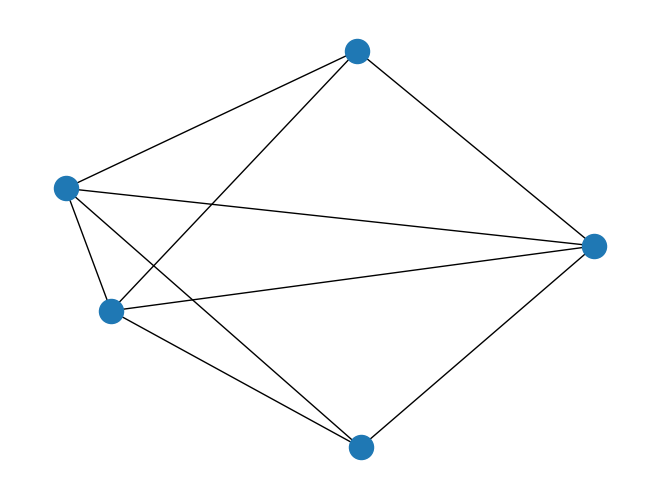

In [2]:
graphset_1 = gs.array(
    [
        nx.to_numpy_array(nx.erdos_renyi_graph(n=5, p=0.6, directed=True))
        for i in range(10)
    ]
)
graphset_2 = gs.array(
    [
        nx.to_numpy_array(nx.erdos_renyi_graph(n=5, p=0.6, directed=True))
        for i in range(100)
    ]
)
graphset_3 = gs.array(
    [
        nx.to_numpy_array(nx.erdos_renyi_graph(n=3, p=0.6, directed=True))
        for i in range(1000)
    ]
)

nx.draw(nx.from_numpy_array(graphset_1[0]))

### A primer in space, metric and aligners

The first step is to create the embedding space. By default, it comes equipped with a metric.

In [3]:
graph_space = GraphSpace(n_nodes=5)

graph_space.metric

By default, the space also comes with a total space (`Matrices`), which in turn comes equipped with a matrix (`MatricesMetric`).

In [4]:
graph_space.total_space.metric

(`total_metric` can also be accessed from metric: `graph_space.metric.total_space_metric`.)

The default aligner is 'ID' (identity), which means the graphs are not permuted. To set 'FAQ', do:

In [5]:
graph_space.metric.set_aligner("FAQ")

With the FAQ alignment and the default Frobenious norm, we match two graphs and a set of graphs to a base graph:

In [6]:
graph_permuted = graph_space.metric.align_point_to_point(
    base_graph=graphset_1[0], graph_to_permute=graphset_1[1]
)

graph_space.metric.align_point_to_point(
    base_graph=graphset_1[0], graph_to_permute=graphset_1[1:3]
)

array([[[0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]]])

To compute the distance we can either call the distance function:

In [7]:
graph_space.metric.dist(graphset_1[0], graphset_1[1])

2.6457513110645907

Or, if the matching has been already run, we can use the identity matcher in the distance, to avoid computing the matching twice:

In [8]:
graph_space.metric.set_aligner("ID")

graph_space.metric.dist(graphset_1[0], graph_permuted)

2.6457513110645907

Alternatively, use can use the total space metric instead.

In [9]:
graph_space.metric.total_space_metric.dist(graphset_1[0], graph_permuted)

2.6457513110645907

We can change the total space metric by doing:

In [10]:
graph_space.total_space.equip_with_metric(SymmetricMatricesMetric)

For the point to geodesic aligner, there's no default set. In fact, if you try something like `graph_space.metric.align_point_to_geodesic(geodesic, point)`, a (hopefully) meaningful error will be raised, explaining how to set the point to geodesic aligner.

In [11]:
graph_space.metric.set_point_to_geodesic_aligner(
    "default", s_min=-1.0, s_max=1.0, n_points=10
)

In [12]:
init_point, end_point = graph_space.random_point(2)

geodesic_func = graph_space.metric.geodesic(init_point, end_point)

aligned_init_point = graph_space.metric.align_point_to_geodesic(
    geodesic_func, init_point
)

graph_space.metric.total_space_metric.dist(init_point, aligned_init_point)

0.0

This short introduction should be enough to set you up for experimenting with the learning algorithms on graphs.

### Frechet Mean
Reference: Calissano, A., Feragen, A., & Vantini, S. (2020). Populations of unlabeled networks: Graph space geometry and geodesic principal components. MOX Report.

Given $\{[X_1], \dots, [X_k]\}, [x_i] \in X/T$, we estimate the Frechet Mean using AAC consisting on two steps:
1. Compute $\hat{X}$ as arithmetic mean of $\{X_1, \dots, X_k\}, X_i \in X$ 
2. Using graph to graph alignment to find $\{X_1, \dots, X_k\}, X_i \in X$ optimally aligned with $\hat{X}$

Let's instantiate the graph space and set the aligner.

In [13]:
graph_space = GraphSpace(n_nodes=5)

graph_space.metric.set_aligner("FAQ")

And now create the estimator, and fit the data.

In [14]:
aac_fm = AAC(estimate="frechet_mean", metric=graph_space.metric)

fm = aac_fm.fit(graphset_2)

fm.estimate_

array([[0.  , 0.82, 0.81, 0.4 , 0.34],
       [0.95, 0.  , 0.87, 0.59, 0.79],
       [0.51, 0.4 , 0.  , 0.28, 0.16],
       [0.88, 0.81, 0.73, 0.  , 0.6 ],
       [0.61, 0.46, 0.7 , 0.07, 0.  ]])

### Principal Components
Reference: Calissano, A., Feragen, A., & Vantini, S. (2020). Populations of unlabeled networks: Graph space geometry and geodesic principal components. MOX Report.

We estimate the Generalized Geodesics Principal Components Analysis (GGPCA) using AAC. Given $\{[X_1], \dots, [X_k]\}, (s_i,[X_i]) \in X/T $ we are searching for:
$$\gamma: \mathbb{R}\rightarrow X/T$$ generalized geodesic principal component capturing the majority of the variability of the dataset. The AAC for ggpca works in two steps: 

1. finding $\delta: \mathbb{R}\rightarrow X$ principal component in the set of adjecency matrices $\{X_1, \dots, X_k\}, X_i \in X$ 
2. finding $\{X_1, \dots, X_k\}, X_i \in X$ as optimally aligned with respect to $\gamma$. The estimation required a point to geodesic aligment defined in the metric.

As before:

In [15]:
graph_space = GraphSpace(n_nodes=5)

graph_space.metric.set_aligner("FAQ")

For GGPCA, we also need to set the pont to geodesic aligner.

In [16]:
graph_space.metric.set_point_to_geodesic_aligner("default", s_min=0, s_max=2)

Again, create the estimator and fit the data.

In [17]:
aac_ggpca = AAC(estimate="ggpca", metric=graph_space.metric, n_components=2)

aac_ggpca.fit(graphset_3);

## Regression
Reference: Calissano, A., Feragen, A., & Vantini, S. (2022). Graph-valued regression: Prediction of unlabelled networks in a non-Euclidean graph space. Journal of Multivariate Analysis, 190, 104950.

We estimate a graph-to-value regression model to predict graph from scalar or vectors. Given $\{(s_1,[X_1]), \dots, (s_k, [X_k])\}, (s_i,[X_i]) \in \mathbb{R}^p\times X/T $ we are searching for:
$$f: \mathbb{R}^p\rightarrow X/T$$
where $f\in \mathcal{F}(X/T)$ is a generalized geodesic regression model, i.e., the canonical projection onto Graph Space of a regression line $h_\beta : \mathbb{R}^p\rightarrow X$ of the form $$h_\beta(s) = \sum_{j=1}^{p} \beta_i s_i$$
The AAC algorithm for regression combines the estimation of $h_\beta$ given $\{X_1, \dots, X_k\}, X_i \in X$
$$\sum_{i=0}^{k} d_X(h_\beta(s_i), X_i)$$
and the searching for $\{X_1, \dots, X_k\}, X_i \in X$ optimally aligned with respect to the prediction along the current regression model:
$$\min_{t\in T}d_X(h_\beta(s_i),t^TX_it)$$

In [18]:
graph_space = GraphSpace(n_nodes=5)

graph_space.metric.set_aligner("FAQ")

In [19]:
s = gs.array([random.randint(0, 10) for i in range(10)])

In [20]:
aac_reg = AAC(estimate="regression", metric=graph_space.metric)

In [21]:
aac_reg.fit(s, graphset_1);

The coefficients are saved in the following attributes and they can be changed into a graph shape.

In [22]:
aac_reg.total_space_estimator.coef_

array([[-0.        ],
       [-0.09958506],
       [-0.05394191],
       [ 0.02904564],
       [-0.06639004],
       [-0.02904564],
       [-0.        ],
       [ 0.05394191],
       [ 0.01659751],
       [-0.04564315],
       [-0.        ],
       [ 0.0373444 ],
       [-0.        ],
       [-0.03319502],
       [ 0.0746888 ],
       [ 0.09543568],
       [ 0.02489627],
       [ 0.00829876],
       [-0.        ],
       [-0.11618257],
       [-0.0746888 ],
       [ 0.09128631],
       [ 0.10373444],
       [ 0.04979253],
       [-0.        ]])

A graph can be predicted using the fit model and the corresponding prediction error can be computed:

In [23]:
graph_pred = aac_reg.total_space_estimator.predict(s)

gs.sum(graph_space.metric.dist(graphset_1, graph_pred))

16.511901318893987